<h1>Data Science Capstone Project</h1>
<h3><em>by: Klyde Jasper Jose</em></h3>

<h2>Introduction/Business problem</h2>

<p > Metro Manila, simply Manila, is the National Capital Region and the Philippines' prime tourist destination. Manila comprises 17 cities and municipalities, including the capital city, Manila City. Though it is the smallest region in the country, Metro Manila is the most populous of the twelve defined metropolitan areas in the Philippines and the 19th most populous in the world (Koop, 2021). Being the capital, Manila is considered to be the center of commerce, education, and entertainment of the country.

In this Capstone Project, I want to know the most common places available to Manila's people. After I determine the Top 3 Most Common Places, I will cluster the type of place and determine what kind of establishment is best to set up in a particular city. Lastly, I also want to know the most common cuisines people prefer to eat here in the metro.

Link to Koop, 2021: https://www.visualcapitalist.com/most-populous-cities-in-the-world/
</p>


<h2>Description of the data</h2>

<p>The different districts present in Metro Manila were obtained from the Philippines Statistics Authority records (PSA). Every city has been divided into different smaller neighborhoods or "barangays," as termed in the Philippines. To make the data processing easier, Microsoft Excel is used to clean the PSA data while also retaining the different Metro Manila cities.

Each city's central location's latitude and longitude is requested from Google Cloud's Geocoding API. These coordinates will then be used as input in the Foursquare API, which is used to obtain the different venues present at each city within a 3000-meter radius relative to its coordinates.

Lastly, from the Foursquare API's response, the result will be parsed to obtain necessary values such as each venue's coordinates, name, venue sub-category, and main category. The main type is how Foursquare classifies the venue. To name a few, this can be food, arts, and education. Venue sub-category is the specific category a venue is classified as, i.e., Japanese Restaurant for Food.

Link to the PSA Data: https://psa.gov.ph/sites/default/files/attachments/hsd/pressrelease/2015_Table%201_Legislative%20Districts.xlsx
</p>

<h2>Methodology</h2>

<b>This notebook will be used to complete the Data Science professional certificate by IBM in Coursera</b>

In [1]:
import pandas as pd
import numpy as np
import ipython_config #used to hide sensitive data
import requests
from bs4 import BeautifulSoup
import urllib.request
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [2]:
data_url="https://psa.gov.ph/sites/default/files/attachments/hsd/pressrelease/2015_Table%201_Legislative%20Districts.xlsx"
cities_borough_url = ipython_config.cities_borough_url
agriculutral_accounts = "https://psa.gov.ph/system/files/01Summary_2018PSNA_Q42020_8.xlsx"

#References:
#https://psa.gov.ph/national-accounts/base-2018/estimates

Load Data

In [3]:
NCR_data = pd.read_excel(cities_borough_url)

In [4]:
NCR_data=NCR_data.rename(columns={'Unnamed: 2': 'Latitude', 'Unnamed: 3':'Longtitude'})
NCR_data=NCR_data.drop(['Unnamed: 4'], axis=1)
NCR_data.drop(index=list(range(17,26)), inplace=True)

In [5]:
NCR_data

,City,2015 Population,Latitude,Longtitude
0,CITY OF MANILA,1780148.0,NaN,NaN
1,CITY OF MANDALUYONG,386276.0,NaN,NaN
2,CITY OF MARIKINA,450741.0,NaN,NaN
3,CITY OF PASIG,755300.0,NaN,NaN
4,QUEZON CITY,2936116.0,NaN,NaN
5,CITY OF SAN JUAN,122180.0,NaN,NaN
6,CALOOCAN CITY,1583978.0,NaN,NaN
7,CITY OF MALABON,365525.0,NaN,NaN
8,CITY OF NAVOTAS,249463.0,NaN,NaN
9,CITY OF VALENZUELA,620422.0,NaN,NaN


In [6]:
#API Keys for Google Geocoders and Foursquare
geocoders_APIkey = ipython_config.geocoders_APIkey
foursquare_ID = ipython_config.foursquare_ID
foursquare_secret= ipython_config.foursquare_secret
foursquare_version = '20210315'
foursquare_limit = 100

In [7]:
for ind, row in NCR_data.iterrows():
    address = str(NCR_data.at[ind, 'City']) + ", Philippines"
    parameters ={
    "key": geocoders_APIkey,
    "address": address
    }
    response = requests.get("https://maps.googleapis.com/maps/api/geocode/json?",params = parameters)
    
    data = json.loads(response.text)["results"][0]["geometry"]
    lat = data["location"]["lat"]
    lng = data["location"]["lng"]

    NCR_data.at[ind, 'Latitude'] = lat
    NCR_data.at[ind, 'Longtitude'] = lng

In [8]:
NCR_data.head()

,City,2015 Population,Latitude,Longtitude
0,CITY OF MANILA,1780148.0,14.599512,120.984219
1,CITY OF MANDALUYONG,386276.0,14.579444,121.035917
2,CITY OF MARIKINA,450741.0,14.650730,121.102855
3,CITY OF PASIG,755300.0,14.576377,121.085110
4,QUEZON CITY,2936116.0,14.676041,121.043700


In [9]:
#NCR_data.to_excel("NCR_data.xlsx")

In [10]:
# create map of New York using latitude and longitude values
NCR_map = folium.Map(location=[NCR_data.at[0, 'Latitude'], NCR_data.at[0, 'Longtitude']], zoom_start=11)

# add markers to map
for lat, lng, city in zip(NCR_data['Latitude'], NCR_data['Longtitude'], NCR_data['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NCR_map)  
    
NCR_map

<h3>Data Collection</h3>

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    short_cat_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            foursquare_ID, 
            foursquare_secret,  
            foursquare_version, 
            lat, 
            lng, 
            radius, 
            foursquare_limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        for w in results:
            string = (w['venue']['categories'][0]['icon']['prefix'])
            short_cat = string.split(sep='/')
            short_cat_list.append(short_cat[5]) 

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    nearby_venues['Short Category']=short_cat_list
    
    return(nearby_venues)

In [12]:
NCR_venues = getNearbyVenues(NCR_data['City'], NCR_data['Latitude'], NCR_data['Longtitude'], 3000) #radius of 1500m
NCR_venues.shape

CITY OF MANILA
CITY OF MANDALUYONG
CITY OF MARIKINA
CITY OF PASIG
QUEZON CITY
CITY OF SAN JUAN
CALOOCAN CITY 
CITY OF MALABON
CITY OF NAVOTAS
CITY OF VALENZUELA
CITY OF LAS PIÑAS
CITY OF MAKATI
CITY OF MUNTINLUPA
CITY OF PARAÑAQUE
PASAY CITY
PATEROS
TAGUIG CITY


(1625, 8)

In [13]:
#NCR_venues.to_excel("NCR_venues.xlsx")

In [14]:
NCR_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Short Category
0,CITY OF MANILA,14.599512,120.984219,Krispy Kreme,14.601195,120.982774,Donut Shop,food
1,CITY OF MANILA,14.599512,120.984219,BonChon Chicken,14.601194,120.982791,Fried Chicken Joint,food
2,CITY OF MANILA,14.599512,120.984219,98B,14.598836,120.979435,Public Art,arts_entertainment
3,CITY OF MANILA,14.599512,120.984219,The Den,14.598827,120.979450,Coffee Shop,food
4,CITY OF MANILA,14.599512,120.984219,Minor Basilica of St. Lorenzo Ruiz of Manila (...,14.599935,120.974646,Church,building


In [15]:
#Obain the count for number of Venues in each city
NCR_venues[['City','Venue Category']].groupby('City').count()

,Venue Category
City,
CALOOCAN CITY,100
CITY OF LAS PIÑAS,100
CITY OF MAKATI,100
CITY OF MALABON,93
CITY OF MANDALUYONG,100
CITY OF MANILA,100
CITY OF MARIKINA,88
CITY OF MUNTINLUPA,100
CITY OF NAVOTAS,48


In [16]:
#Obtain the Number of Main categories for the whole Metro Manila
NCR_venues[['Short Category']].value_counts()

Short Category    
food                  1082
shops                  324
arts_entertainment      56
building                45
parks_outdoors          44
travel                  36
nightlife               35
education                3
dtype: int64

In [17]:
print('There are {} uniques categories and {} sub-categories.'.format(len(NCR_venues['Short Category'].unique()),len(NCR_venues['Venue Category'].unique())))

There are 8 uniques categories and 201 sub-categories.


<h3>Analysis of Top 3 Types of Venues</h3>

In [18]:
# one hot encoding
NCR_onehot = pd.get_dummies(NCR_venues[['Short Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NCR_onehot['City'] = NCR_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [NCR_onehot.columns[-1]] + list(NCR_onehot.columns[:-1])
NCR_onehot = NCR_onehot[fixed_columns]

NCR_onehot.shape

(1625, 9)

In [19]:
NCR_total_short_cat = NCR_onehot.groupby('City').sum()

In [20]:
NCR_total_short_cat.head()

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
City,,,,,,,,
CALOOCAN CITY,3,1,0,59,1,0,36,0
CITY OF LAS PIÑAS,2,3,0,72,5,1,17,0
CITY OF MAKATI,1,3,0,62,2,1,24,7
CITY OF MALABON,3,0,0,63,2,4,21,0
CITY OF MANDALUYONG,5,3,0,67,4,0,18,3


In [21]:
X= NCR_total_short_cat.values[:,0:]
NCR_total_short_cat_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X))
NCR_total_short_cat_scaled.columns = list(NCR_total_short_cat.columns)

In [22]:
NCR_total_short_cat_scaled.head()

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,0.4,0.142857,0.0,0.605263,0.2,0.000,1.000000,0.000
1,0.2,0.428571,0.0,0.947368,1.0,0.125,0.366667,0.000
2,0.0,0.428571,0.0,0.684211,0.4,0.125,0.600000,0.875
3,0.4,0.000000,0.0,0.710526,0.4,0.500,0.500000,0.000
4,0.8,0.428571,0.0,0.815789,0.8,0.000,0.400000,0.375


In [23]:
#NCR_total_short_cat_scaled.to_excel("NCR_total_short_cat_scaled.xlsx")

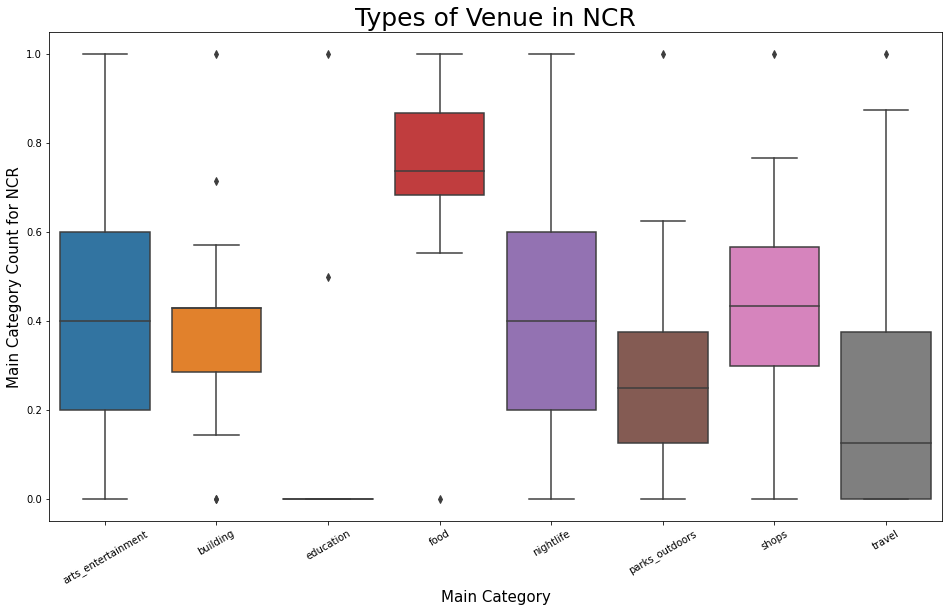

In [24]:
plt.figure(figsize=(16,9))
ax = sns.boxplot(data = NCR_total_short_cat_scaled)
ax.set_title('Types of Venue in NCR', fontsize=25)
ax.set_xlabel('Main Category', fontsize=15)
ax.set_ylabel('Main Category Count for NCR', fontsize=15)
ax.tick_params(labelsize=10)
plt.xticks(rotation=30, ha='center')

plt.show()

In [28]:
NCR_cat_sorted=NCR_total_short_cat_scaled.join(NCR_data['City'].sort_values(ascending = True).reset_index(drop=True))
cols = NCR_cat_sorted.columns.tolist()
cols = cols[-1:] + cols[:-1]
NCR_cat_sorted = NCR_cat_sorted[cols]
NCR_cat_sorted.head(2)

,City,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,CALOOCAN CITY,0.4,0.142857,0.0,0.605263,0.2,0.000,1.000000,0.0
1,CITY OF LAS PIÑAS,0.2,0.428571,0.0,0.947368,1.0,0.125,0.366667,0.0


In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))


# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = NCR_cat_sorted['City']

for ind in np.arange(NCR_cat_sorted.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NCR_cat_sorted.iloc[ind, :], num_top_venues)

city_venues_sorted=city_venues_sorted.drop(['City'], axis=1)

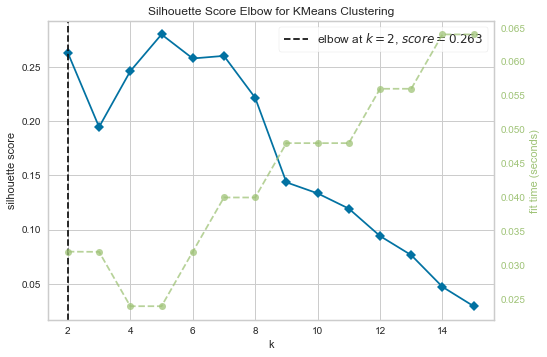

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [31]:
#Determine optimal number of clusters
#  Silhouette Score for K means
#Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
NCR_main_cat_clustering = NCR_total_short_cat_scaled.copy()
visualizer = KElbowVisualizer(model, k=(2,16),metric='silhouette', timings= True)
visualizer.fit(NCR_main_cat_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [32]:
# set number of clusters
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NCR_main_cat_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
NCR_main_cat_clustering['Cluster']=kmeans.labels_

In [33]:
NCR_main_cat_clustering

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Cluster
0,0.4,0.142857,0.0,0.605263,0.2,0.000,1.000000,0.000,0
1,0.2,0.428571,0.0,0.947368,1.0,0.125,0.366667,0.000,3
2,0.0,0.428571,0.0,0.684211,0.4,0.125,0.600000,0.875,1
3,0.4,0.000000,0.0,0.710526,0.4,0.500,0.500000,0.000,0
4,0.8,0.428571,0.0,0.815789,0.8,0.000,0.400000,0.375,3
5,1.0,0.714286,1.0,0.973684,0.0,0.375,0.000000,0.625,2
6,1.0,0.285714,0.5,0.763158,0.2,0.250,0.133333,0.125,2
7,0.4,0.428571,0.0,0.736842,0.2,0.375,0.466667,0.750,1
8,0.0,0.000000,0.0,0.000000,0.4,0.125,0.066667,0.000,0
9,0.2,1.000000,0.0,0.894737,0.8,0.250,0.300000,0.000,3


In [34]:
#NCR_main_cat_clustering.to_excel("NCR_main_cat_clustering.xlsx")

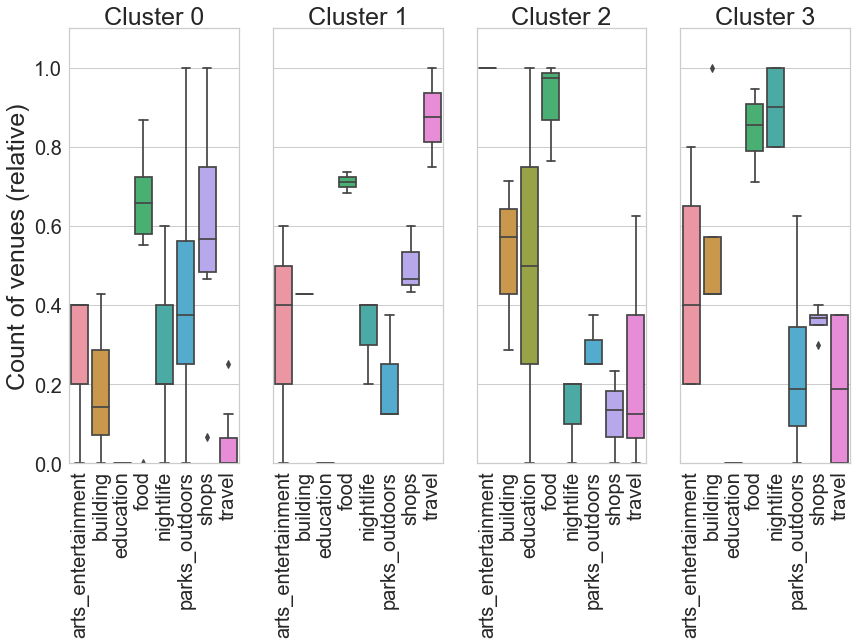

In [35]:
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(0, 4):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = NCR_main_cat_clustering[NCR_main_cat_clustering['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [34]:
NCR_main_cat_clustering.head()

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Cluster
0,0.4,0.142857,0.0,0.600000,0.2,0.000,1.000000,0.000,3
1,0.2,0.428571,0.0,0.971429,1.0,0.125,0.366667,0.000,1
2,0.0,0.428571,0.0,0.742857,0.4,0.125,0.566667,0.750,2
3,0.2,0.000000,0.0,0.657143,0.4,0.500,0.433333,0.000,3
4,0.8,0.428571,0.0,0.828571,0.4,0.000,0.400000,0.625,2


In [36]:
city_venues_sorted.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,shops,food,arts_entertainment
1,nightlife,food,building
2,travel,food,shops
3,food,parks_outdoors,shops
4,food,arts_entertainment,nightlife


In [40]:
NCR_merged_typeOfVenue = NCR_data.sort_values(by=['City']).reset_index(drop=True).join(NCR_main_cat_clustering)
NCR_merged_typeOfVenue1=NCR_merged_typeOfVenue.join(city_venues_sorted)
NCR_merged_typeOfVenue

,City,2015 Population,Latitude,Longtitude,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel,Cluster
0,CALOOCAN CITY,1583978.0,14.756578,121.044977,0.4,0.142857,0.0,0.605263,0.2,0.000,1.000000,0.000,0
1,CITY OF LAS PIÑAS,588894.0,14.444546,120.993874,0.2,0.428571,0.0,0.947368,1.0,0.125,0.366667,0.000,3
2,CITY OF MAKATI,582602.0,14.554729,121.024445,0.0,0.428571,0.0,0.684211,0.4,0.125,0.600000,0.875,1
3,CITY OF MALABON,365525.0,14.668075,120.965845,0.4,0.000000,0.0,0.710526,0.4,0.500,0.500000,0.000,0
4,CITY OF MANDALUYONG,386276.0,14.579444,121.035917,0.8,0.428571,0.0,0.815789,0.8,0.000,0.400000,0.375,3
5,CITY OF MANILA,1780148.0,14.599512,120.984219,1.0,0.714286,1.0,0.973684,0.0,0.375,0.000000,0.625,2
6,CITY OF MARIKINA,450741.0,14.650730,121.102855,1.0,0.285714,0.5,0.763158,0.2,0.250,0.133333,0.125,2
7,CITY OF MUNTINLUPA,504509.0,14.408133,121.041467,0.4,0.428571,0.0,0.736842,0.2,0.375,0.466667,0.750,1
8,CITY OF NAVOTAS,249463.0,14.673218,120.935011,0.0,0.000000,0.0,0.000000,0.4,0.125,0.066667,0.000,0
9,CITY OF PARAÑAQUE,665822.0,14.479309,121.019823,0.2,1.000000,0.0,0.894737,0.8,0.250,0.300000,0.000,3


In [41]:
typeOfVenue_clusters = folium.Map(location=[NCR_data.at[0, 'Latitude'], NCR_data.at[0, 'Longtitude']], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NCR_merged_typeOfVenue['Latitude'], NCR_merged_typeOfVenue['Longtitude'], NCR_merged_typeOfVenue['City'], NCR_merged_typeOfVenue['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=(int(cluster)+1)*5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(typeOfVenue_clusters)

typeOfVenue_clusters

<h3>Most Common Type of Venue per City, Grouped</h3>

In [42]:
NCR_merged_typeOfVenue1.loc[NCR_merged_typeOfVenue1['Cluster'] == 0, NCR_merged_typeOfVenue1.columns[[0] + list(range(12, NCR_merged_typeOfVenue1.shape[1]))]]

,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,CALOOCAN CITY,0,shops,food,arts_entertainment
3,CITY OF MALABON,0,food,parks_outdoors,shops
8,CITY OF NAVOTAS,0,nightlife,parks_outdoors,shops
10,CITY OF PASIG,0,food,shops,building
12,CITY OF VALENZUELA,0,shops,parks_outdoors,food
15,QUEZON CITY,0,shops,food,nightlife
16,TAGUIG CITY,0,parks_outdoors,food,shops


In [43]:
NCR_merged_typeOfVenue1.loc[NCR_merged_typeOfVenue1['Cluster'] == 1, NCR_merged_typeOfVenue1.columns[[0] + list(range(12, NCR_merged_typeOfVenue1.shape[1]))]]

,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,CITY OF MAKATI,1,travel,food,shops
7,CITY OF MUNTINLUPA,1,travel,food,shops
13,PASAY CITY,1,travel,food,arts_entertainment


In [44]:
NCR_merged_typeOfVenue1.loc[NCR_merged_typeOfVenue1['Cluster'] == 2, NCR_merged_typeOfVenue1.columns[[0] + list(range(12, NCR_merged_typeOfVenue1.shape[1]))]]

,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
5,CITY OF MANILA,2,arts_entertainment,education,food
6,CITY OF MARIKINA,2,arts_entertainment,food,education
11,CITY OF SAN JUAN,2,arts_entertainment,food,building


In [45]:
NCR_merged_typeOfVenue1.loc[NCR_merged_typeOfVenue1['Cluster'] == 3, NCR_merged_typeOfVenue1.columns[[0] + list(range(12, NCR_merged_typeOfVenue1.shape[1]))]]

,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,CITY OF LAS PIÑAS,3,nightlife,food,building
4,CITY OF MANDALUYONG,3,food,arts_entertainment,nightlife
9,CITY OF PARAÑAQUE,3,building,food,nightlife
14,PATEROS,3,nightlife,food,parks_outdoors


NCR_venue_cat = NCR_venues['Venue Category'].value_counts().to_frame()
NCR_venue_cat = pd.read_excel(ipython_config.venue_cat_data_xlsx)
NCR_venue_cat.head()

<!--#pd.set_option('display.max_rows', 200)
#pd.reset_option('all')--!>

<h3>Determination of Popular Cuisines</h3>

Recap of data

In [46]:
NCR_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Short Category
0,CITY OF MANILA,14.599512,120.984219,Krispy Kreme,14.601195,120.982774,Donut Shop,food
1,CITY OF MANILA,14.599512,120.984219,BonChon Chicken,14.601194,120.982791,Fried Chicken Joint,food
2,CITY OF MANILA,14.599512,120.984219,98B,14.598836,120.979435,Public Art,arts_entertainment
3,CITY OF MANILA,14.599512,120.984219,The Den,14.598827,120.979450,Coffee Shop,food
4,CITY OF MANILA,14.599512,120.984219,Minor Basilica of St. Lorenzo Ruiz of Manila (...,14.599935,120.974646,Church,building


In [47]:
NCR_venues.shape

(1625, 8)

In [48]:
#obtain data for food related locations
NCR_cuisines = NCR_venues[NCR_venues['Short Category'] == 'food']
NCR_cuisines = NCR_cuisines.reset_index(drop=True)
NCR_cuisines.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Short Category
0,CITY OF MANILA,14.599512,120.984219,Krispy Kreme,14.601195,120.982774,Donut Shop,food
1,CITY OF MANILA,14.599512,120.984219,BonChon Chicken,14.601194,120.982791,Fried Chicken Joint,food
2,CITY OF MANILA,14.599512,120.984219,The Den,14.598827,120.979450,Coffee Shop,food
3,CITY OF MANILA,14.599512,120.984219,Wai Ying Fastfood (嶸嶸小食館),14.601992,120.975985,Chinese Restaurant,food
4,CITY OF MANILA,14.599512,120.984219,Ying Ying Tea House,14.597885,120.976729,Chinese Restaurant,food


In [49]:
f"There are {NCR_cuisines[['Short Category']].value_counts().sum()} items relating to food"

'There are 1082 items relating to food'

In [50]:
cuisines_data = NCR_cuisines['Venue Category'].value_counts(sort=True).to_frame().reset_index()
cuisines_data.rename(index = str, columns ={'index':'Cuisine','Venue Category':'Count'}, inplace=True )

In [51]:
cuisines_data.head()

,Cuisine,Count
0,Coffee Shop,107
1,Fast Food Restaurant,78
2,Café,76
3,Filipino Restaurant,74
4,Chinese Restaurant,60


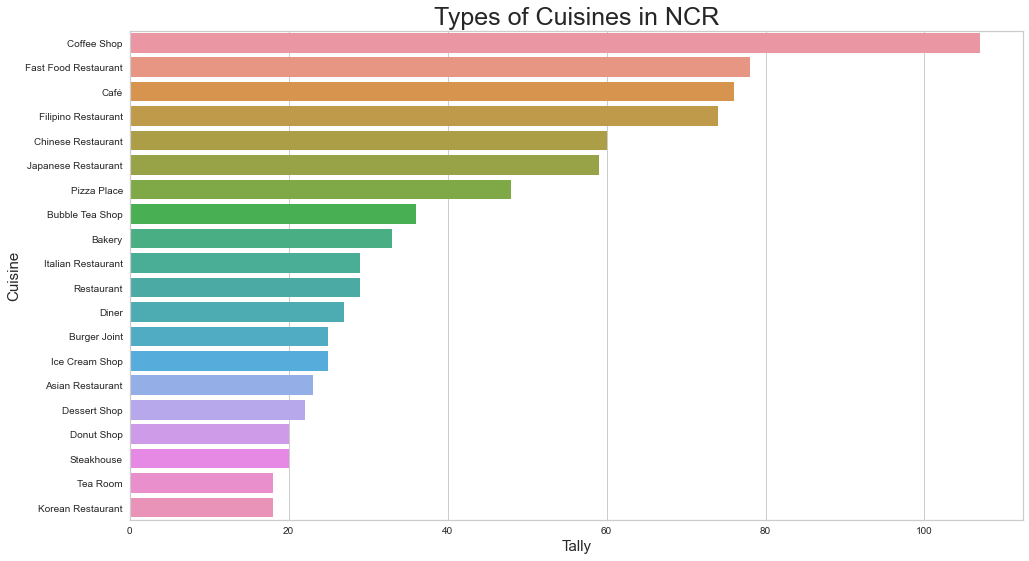

In [52]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x="Count", y="Cuisine",data = cuisines_data[:20], orient='h')
ax.set_title('Types of Cuisines in NCR', fontsize=25)
ax.set_ylabel('Cuisine', fontsize=15)
ax.set_xlabel('Tally', fontsize=15)
ax.tick_params(labelsize=10)
plt.yticks(rotation='horizontal')

plt.show()

In [53]:
#NCR_cuisines.to_excel('NCR_cuisines.xlsx')

<h3>Looking at Data Distribution</h3>

In [54]:
count, bin_edges = np.histogram(cuisines_data['Count'])
f"Frequency is {count} and bin ranges are {bin_edges}"

'Frequency is [51  9  6  2  1  2  1  2  0  1] and bin ranges are [  1.   11.6  22.2  32.8  43.4  54.   64.6  75.2  85.8  96.4 107. ]'

<AxesSubplot:ylabel='Frequency'>

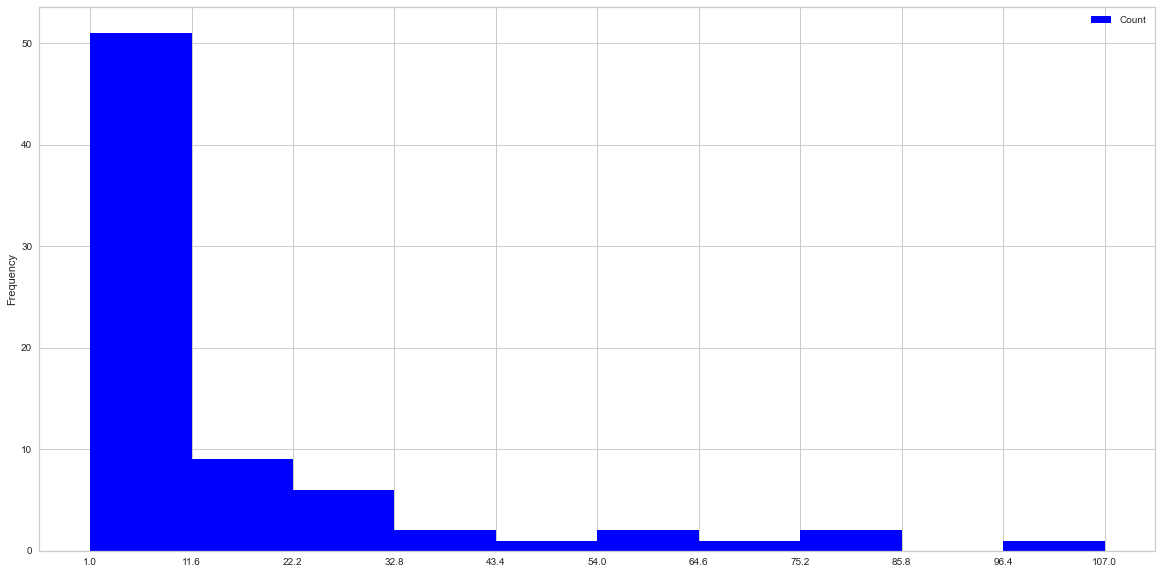

In [55]:
cuisines_data.plot(kind='hist',figsize =(20,10),xticks=bin_edges, color='blue')

Majority of data is in the right, and are small values. As much as possible, these daa points should be removed to avoid outliers.

In [56]:
#obtain rows for venue category with countss less than 11.7
cuisines_to_remove = cuisines_data[cuisines_data['Count'] < 11.7]

In [57]:
cuisines_to_remove.shape

(51, 2)

In [58]:
remove_rows = cuisines_to_remove['Cuisine'].tolist()

In [59]:
f"Number of Rows to be removed is {cuisines_to_remove['Count'].sum()}"

'Number of Rows to be removed is 206'

In [60]:
NCR_cuisines_cleaned = NCR_cuisines[~NCR_cuisines['Venue Category'].isin(remove_rows)]

In [61]:
f"Original Number of columns from NCR_venues DataFrame is {NCR_cuisines.shape[0]}"

'Original Number of columns from NCR_venues DataFrame is 1082'

In [62]:
if (NCR_cuisines_cleaned.shape[0] == (NCR_cuisines.shape[0]-cuisines_to_remove['Count'].sum())):
    print("Successfully removed rows")

Successfully removed rows


<h4>Proceed to onehat encoding</h4>

In [63]:
# one hot encoding
cuisines_onehot = pd.get_dummies(NCR_cuisines_cleaned[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cuisines_onehot['City'] = NCR_cuisines_cleaned['City'] 

# move neighborhood column to the first column
fixed_columns = [cuisines_onehot.columns[-1]] + list(cuisines_onehot.columns[:-1])
cuisines_onehot = cuisines_onehot[fixed_columns]

cuisines_onehot.shape

(876, 25)

In [64]:
cuisines_onehot.head()

,City,Asian Restaurant,BBQ Joint,Bakery,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,...,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Restaurant,Snack Place,Steakhouse,Tea Room,Wings Joint
0,CITY OF MANILA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CITY OF MANILA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CITY OF MANILA,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,CITY OF MANILA,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CITY OF MANILA,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
cuisines_onehot_total = cuisines_onehot.groupby('City').mean().reset_index()
cuisines_onehot_total.shape

(17, 25)

In [66]:
cuisines_onehot_total.head()

,City,Asian Restaurant,BBQ Joint,Bakery,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,...,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Restaurant,Snack Place,Steakhouse,Tea Room,Wings Joint
0,CALOOCAN CITY,0.017857,0.000000,0.071429,0.035714,0.053571,0.071429,0.017857,0.107143,0.017857,...,0.035714,0.000000,0.017857,0.000000,0.107143,0.017857,0.000000,0.000000,0.000000,0.017857
1,CITY OF LAS PIÑAS,0.000000,0.031250,0.015625,0.046875,0.015625,0.046875,0.046875,0.093750,0.015625,...,0.000000,0.046875,0.125000,0.015625,0.062500,0.046875,0.015625,0.015625,0.062500,0.015625
2,CITY OF MAKATI,0.023810,0.023810,0.047619,0.000000,0.000000,0.190476,0.023810,0.166667,0.000000,...,0.023810,0.119048,0.142857,0.071429,0.000000,0.047619,0.000000,0.023810,0.000000,0.000000
3,CITY OF MALABON,0.070175,0.000000,0.017544,0.070175,0.035088,0.087719,0.122807,0.052632,0.052632,...,0.017544,0.000000,0.000000,0.000000,0.070175,0.000000,0.017544,0.017544,0.052632,0.000000
4,CITY OF MANDALUYONG,0.000000,0.040816,0.061224,0.020408,0.000000,0.081633,0.061224,0.081633,0.040816,...,0.020408,0.081633,0.142857,0.040816,0.000000,0.061224,0.000000,0.040816,0.020408,0.000000


In [67]:
num_top_venues = 8

for hood in cuisines_onehot_total['City']:
    print("----"+hood+"----")
    temp = cuisines_onehot_total[cuisines_onehot_total['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CALOOCAN CITY ----
                  venue  freq
0  Fast Food Restaurant  0.25
1           Coffee Shop  0.11
2           Pizza Place  0.11
3   Filipino Restaurant  0.07
4                Bakery  0.07
5                  Café  0.07
6          Burger Joint  0.05
7        Ice Cream Shop  0.04


----CITY OF LAS PIÑAS----
                  venue  freq
0   Filipino Restaurant  0.12
1   Japanese Restaurant  0.12
2           Coffee Shop  0.09
3              Tea Room  0.06
4  Fast Food Restaurant  0.06
5           Pizza Place  0.06
6       Bubble Tea Shop  0.05
7                  Café  0.05


----CITY OF MAKATI----
                 venue  freq
0                 Café  0.19
1          Coffee Shop  0.17
2  Japanese Restaurant  0.14
3   Italian Restaurant  0.12
4  Filipino Restaurant  0.07
5    Korean Restaurant  0.07
6               Bakery  0.05
7           Restaurant  0.05


----CITY OF MALABON----
                  venue  freq
0  Fast Food Restaurant  0.18
1    Chinese Restaurant  0.12
2      

In [68]:
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = cuisines_onehot_total['City']

for ind in np.arange(cuisines_onehot_total.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cuisines_onehot_total.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,CALOOCAN CITY,Fast Food Restaurant,Coffee Shop,Pizza Place,Filipino Restaurant,Bakery,Café,Burger Joint,Ice Cream Shop
1,CITY OF LAS PIÑAS,Filipino Restaurant,Japanese Restaurant,Coffee Shop,Tea Room,Fast Food Restaurant,Pizza Place,Bubble Tea Shop,Café
2,CITY OF MAKATI,Café,Coffee Shop,Japanese Restaurant,Italian Restaurant,Filipino Restaurant,Korean Restaurant,Bakery,Restaurant
3,CITY OF MALABON,Fast Food Restaurant,Chinese Restaurant,Café,Asian Restaurant,Bubble Tea Shop,Pizza Place,Diner,Tea Room
4,CITY OF MANDALUYONG,Filipino Restaurant,Japanese Restaurant,Café,Coffee Shop,Italian Restaurant,Bakery,Chinese Restaurant,Restaurant


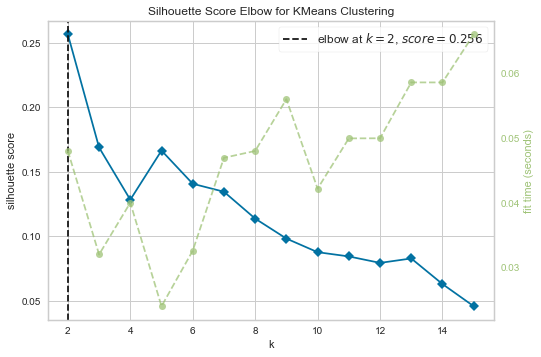

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [69]:
#Determine optimal number of clusters
#  Silhouette Score for K means
#Import ElbowVisualizer
model = KMeans()
# k is range of number of clusters.
cuisines_onehot_clustering = cuisines_onehot_total.drop(['City'], axis=1)
visualizer = KElbowVisualizer(model, k=(2,16),metric='silhouette', timings= True)
visualizer.fit(cuisines_onehot_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [73]:
# set number of clusters
kclusters = 2
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cuisines_onehot_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
cuisines_onehot_clustering['Cluster']=kmeans.labels_

In [74]:
cuisines_onehot_clustering

,Asian Restaurant,BBQ Joint,Bakery,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,Diner,...,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Restaurant,Snack Place,Steakhouse,Tea Room,Wings Joint,Cluster
0,0.017857,0.000000,0.071429,0.035714,0.053571,0.071429,0.017857,0.107143,0.017857,0.035714,...,0.000000,0.017857,0.000000,0.107143,0.017857,0.000000,0.000000,0.000000,0.017857,0
1,0.000000,0.031250,0.015625,0.046875,0.015625,0.046875,0.046875,0.093750,0.015625,0.031250,...,0.046875,0.125000,0.015625,0.062500,0.046875,0.015625,0.015625,0.062500,0.015625,1
2,0.023810,0.023810,0.047619,0.000000,0.000000,0.190476,0.023810,0.166667,0.000000,0.023810,...,0.119048,0.142857,0.071429,0.000000,0.047619,0.000000,0.023810,0.000000,0.000000,1
3,0.070175,0.000000,0.017544,0.070175,0.035088,0.087719,0.122807,0.052632,0.052632,0.052632,...,0.000000,0.000000,0.000000,0.070175,0.000000,0.017544,0.017544,0.052632,0.000000,0
4,0.000000,0.040816,0.061224,0.020408,0.000000,0.081633,0.061224,0.081633,0.040816,0.020408,...,0.081633,0.142857,0.040816,0.000000,0.061224,0.000000,0.040816,0.020408,0.000000,1
5,0.016129,0.000000,0.080645,0.064516,0.016129,0.064516,0.209677,0.096774,0.000000,0.032258,...,0.000000,0.048387,0.032258,0.048387,0.000000,0.032258,0.000000,0.048387,0.016129,1
6,0.020000,0.060000,0.020000,0.060000,0.020000,0.100000,0.020000,0.100000,0.040000,0.080000,...,0.020000,0.040000,0.000000,0.020000,0.060000,0.000000,0.040000,0.000000,0.060000,1
7,0.043478,0.000000,0.000000,0.021739,0.043478,0.108696,0.065217,0.195652,0.043478,0.065217,...,0.065217,0.043478,0.043478,0.065217,0.043478,0.000000,0.021739,0.000000,0.000000,1
8,0.031250,0.031250,0.000000,0.062500,0.031250,0.062500,0.062500,0.000000,0.062500,0.031250,...,0.000000,0.031250,0.000000,0.000000,0.000000,0.031250,0.062500,0.031250,0.000000,0
9,0.066667,0.016667,0.000000,0.083333,0.033333,0.033333,0.050000,0.116667,0.000000,0.050000,...,0.033333,0.066667,0.050000,0.050000,0.050000,0.033333,0.016667,0.033333,0.016667,1


In [76]:
cuisines_clustered = NCR_data.sort_values(by=['City']).reset_index(drop = True).join(cuisines_onehot_clustering)
cuisines_clustered

,City,2015 Population,Latitude,Longtitude,Asian Restaurant,BBQ Joint,Bakery,Bubble Tea Shop,Burger Joint,Café,...,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Pizza Place,Restaurant,Snack Place,Steakhouse,Tea Room,Wings Joint,Cluster
0,CALOOCAN CITY,1583978.0,14.756578,121.044977,0.017857,0.000000,0.071429,0.035714,0.053571,0.071429,...,0.000000,0.017857,0.000000,0.107143,0.017857,0.000000,0.000000,0.000000,0.017857,0
1,CITY OF LAS PIÑAS,588894.0,14.444546,120.993874,0.000000,0.031250,0.015625,0.046875,0.015625,0.046875,...,0.046875,0.125000,0.015625,0.062500,0.046875,0.015625,0.015625,0.062500,0.015625,1
2,CITY OF MAKATI,582602.0,14.554729,121.024445,0.023810,0.023810,0.047619,0.000000,0.000000,0.190476,...,0.119048,0.142857,0.071429,0.000000,0.047619,0.000000,0.023810,0.000000,0.000000,1
3,CITY OF MALABON,365525.0,14.668075,120.965845,0.070175,0.000000,0.017544,0.070175,0.035088,0.087719,...,0.000000,0.000000,0.000000,0.070175,0.000000,0.017544,0.017544,0.052632,0.000000,0
4,CITY OF MANDALUYONG,386276.0,14.579444,121.035917,0.000000,0.040816,0.061224,0.020408,0.000000,0.081633,...,0.081633,0.142857,0.040816,0.000000,0.061224,0.000000,0.040816,0.020408,0.000000,1
5,CITY OF MANILA,1780148.0,14.599512,120.984219,0.016129,0.000000,0.080645,0.064516,0.016129,0.064516,...,0.000000,0.048387,0.032258,0.048387,0.000000,0.032258,0.000000,0.048387,0.016129,1
6,CITY OF MARIKINA,450741.0,14.650730,121.102855,0.020000,0.060000,0.020000,0.060000,0.020000,0.100000,...,0.020000,0.040000,0.000000,0.020000,0.060000,0.000000,0.040000,0.000000,0.060000,1
7,CITY OF MUNTINLUPA,504509.0,14.408133,121.041467,0.043478,0.000000,0.000000,0.021739,0.043478,0.108696,...,0.065217,0.043478,0.043478,0.065217,0.043478,0.000000,0.021739,0.000000,0.000000,1
8,CITY OF NAVOTAS,249463.0,14.673218,120.935011,0.031250,0.031250,0.000000,0.062500,0.031250,0.062500,...,0.000000,0.031250,0.000000,0.000000,0.000000,0.031250,0.062500,0.031250,0.000000,0
9,CITY OF PARAÑAQUE,665822.0,14.479309,121.019823,0.066667,0.016667,0.000000,0.083333,0.033333,0.033333,...,0.033333,0.066667,0.050000,0.050000,0.050000,0.033333,0.016667,0.033333,0.016667,1


In [77]:
cuisine_clusters = folium.Map(location=[NCR_data.at[0, 'Latitude'], NCR_data.at[0, 'Longtitude']], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cuisines_clustered['Latitude'], cuisines_clustered['Longtitude'], cuisines_clustered['City'], cuisines_clustered['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(cuisine_clusters)

cuisine_clusters

In [78]:
cuisines_grouped=cuisines_clustered.join(neighborhoods_venues_sorted.drop(['City'], axis=1))


In [83]:
cuisines_grouped.head()

,City,2015 Population,Latitude,Longtitude,Asian Restaurant,BBQ Joint,Bakery,Bubble Tea Shop,Burger Joint,Café,...,Wings Joint,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,CALOOCAN CITY,1583978.0,14.756578,121.044977,0.017857,0.000000,0.071429,0.035714,0.053571,0.071429,...,0.017857,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Filipino Restaurant,Bakery,Café,Burger Joint,Ice Cream Shop
1,CITY OF LAS PIÑAS,588894.0,14.444546,120.993874,0.000000,0.031250,0.015625,0.046875,0.015625,0.046875,...,0.015625,1,Filipino Restaurant,Japanese Restaurant,Coffee Shop,Tea Room,Fast Food Restaurant,Pizza Place,Bubble Tea Shop,Café
2,CITY OF MAKATI,582602.0,14.554729,121.024445,0.023810,0.023810,0.047619,0.000000,0.000000,0.190476,...,0.000000,1,Café,Coffee Shop,Japanese Restaurant,Italian Restaurant,Filipino Restaurant,Korean Restaurant,Bakery,Restaurant
3,CITY OF MALABON,365525.0,14.668075,120.965845,0.070175,0.000000,0.017544,0.070175,0.035088,0.087719,...,0.000000,0,Fast Food Restaurant,Chinese Restaurant,Café,Asian Restaurant,Bubble Tea Shop,Pizza Place,Diner,Tea Room
4,CITY OF MANDALUYONG,386276.0,14.579444,121.035917,0.000000,0.040816,0.061224,0.020408,0.000000,0.081633,...,0.000000,1,Filipino Restaurant,Japanese Restaurant,Café,Coffee Shop,Italian Restaurant,Bakery,Chinese Restaurant,Restaurant


In [84]:
cuisines_grouped.loc[cuisines_grouped['Cluster'] == 0, cuisines_grouped.columns[[0] + list(range(28, cuisines_grouped.shape[1]))]]

,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,CALOOCAN CITY,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Filipino Restaurant,Bakery,Café,Burger Joint,Ice Cream Shop
3,CITY OF MALABON,0,Fast Food Restaurant,Chinese Restaurant,Café,Asian Restaurant,Bubble Tea Shop,Pizza Place,Diner,Tea Room
8,CITY OF NAVOTAS,0,Filipino Restaurant,Fast Food Restaurant,Bubble Tea Shop,Steakhouse,Café,Chinese Restaurant,Dessert Shop,Tea Room
12,CITY OF VALENZUELA,0,Fast Food Restaurant,Chinese Restaurant,Café,Coffee Shop,Donut Shop,Pizza Place,Bubble Tea Shop,Burger Joint
16,TAGUIG CITY,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Café,Restaurant,Chinese Restaurant,Filipino Restaurant,Japanese Restaurant


In [85]:
cuisines_grouped.loc[cuisines_grouped['Cluster'] == 1, cuisines_grouped.columns[[0] + list(range(28, cuisines_grouped.shape[1]))]]

,City,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
1,CITY OF LAS PIÑAS,1,Filipino Restaurant,Japanese Restaurant,Coffee Shop,Tea Room,Fast Food Restaurant,Pizza Place,Bubble Tea Shop,Café
2,CITY OF MAKATI,1,Café,Coffee Shop,Japanese Restaurant,Italian Restaurant,Filipino Restaurant,Korean Restaurant,Bakery,Restaurant
4,CITY OF MANDALUYONG,1,Filipino Restaurant,Japanese Restaurant,Café,Coffee Shop,Italian Restaurant,Bakery,Chinese Restaurant,Restaurant
5,CITY OF MANILA,1,Chinese Restaurant,Filipino Restaurant,Coffee Shop,Bakery,Ice Cream Shop,Bubble Tea Shop,Café,Tea Room
6,CITY OF MARIKINA,1,Filipino Restaurant,Coffee Shop,Café,Diner,Restaurant,BBQ Joint,Wings Joint,Bubble Tea Shop
7,CITY OF MUNTINLUPA,1,Coffee Shop,Café,Filipino Restaurant,Italian Restaurant,Pizza Place,Chinese Restaurant,Diner,Restaurant
9,CITY OF PARAÑAQUE,1,Coffee Shop,Filipino Restaurant,Bubble Tea Shop,Fast Food Restaurant,Japanese Restaurant,Asian Restaurant,Chinese Restaurant,Diner
10,CITY OF PASIG,1,Coffee Shop,Café,Fast Food Restaurant,Bakery,Restaurant,Japanese Restaurant,Filipino Restaurant,Pizza Place
11,CITY OF SAN JUAN,1,Coffee Shop,Filipino Restaurant,Chinese Restaurant,Japanese Restaurant,Fast Food Restaurant,Ice Cream Shop,Café,Pizza Place
13,PASAY CITY,1,Café,Japanese Restaurant,Coffee Shop,Filipino Restaurant,Pizza Place,Dessert Shop,Steakhouse,Snack Place


<h2>Appendix</h2>

<h3>Capstone Instructions</h3>
<p>
Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve. If you cannot think of an idea or a problem, here are some ideas to get you started:
<ol>
    <li>In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. Is New York City more like Toronto or Paris or some other multicultural city? I will leave it to you to refine this idea.</li>
    <li>In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?</li>
</ol>
These are just a couple of many ideas and problems that can be solved using location data in addition to other datasets. No matter what you decide to do, make sure to provide sufficient justification of why you think what you want to do or solve is important and why would a client or a group of people be interested in your project.
</p>

<h3>Review Criteria</h3>
<p>
This capstone project will be graded by your peers. This capstone project is worth 70% of your total grade. The project will be completed over the course of 2 weeks. Week 1 submissions will be worth 30% whereas Week 2 submissions will be worth 40% of the total grade.

In Week 1, the following are required to be submitted:
<ol>
<li>A description of the problem and a discussion of the background. (15 marks)</li>
<li>A description of the data and how it will be used to solve the problem. (15 marks)</li>
</ol>

For the second week, the final deliverables of the project will be:
<ol>
    <li>A link to the Notebook on its respective Github repository, showing the code. (15 marks)</li>
    <li>A full report consisting of all of the following components (15 marks):</li>
    <ul>
        <li>Introduction where you discuss the business problem and who would be interested in this project.</li>
        <li>Data where you describe the data that will be used to solve the problem and the source of the data.</li>
        <li>Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.</li>
        <li>Results section where you discuss the results.</li>
        <li>Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.</li>
        <li>Conclusion section where you conclude the report.</li>
    </ul>
    <li>Your choice of a presentation or blogpost. (10 marks)</li>
</ol>
</p>